# 利用量桨的 ansatz 模块构造量子电路

_Copyright (c) 2023 Institute for Quantum Computing, Baidu Inc. All Rights Reserved._

`ansatz` 是基于量桨推出的用于实现各种电路拟设功能的工具集。`ansatz` 为量子计算领域的研究者提供了一系列的工具，使他们可以通过设计量子电路实现量子算法等任务。同时，`ansatz` 也提供了方便开发者进行功能扩展的方式。目前 `ansatz` 仍在不断完善，您可以将需求和建议通过 GitHub 的 issue 或 pull request 反馈给我们，我们会及时给出回复。

## 搭建量子电路

量桨提供以下三种方式搭建量子电路：
- **直接利用量子门构造：** 量子电路可以表示为一些单比特量子旋转门和双比特门的组合，量桨中提供了包含 $R_y, R_x, R_z$ 单比特旋转门、双比特 CNOT 门等在内的多种量子门，具体可参见[量桨 API](https://qml.baidu.com/api/paddle_quantum.ansatz.circuit.html)，利用这些量子门我们可以直接搭建量子电路；
- **通过设置 Oracle 构造：** 除了利用量桨提供的量子门构造量子电路外，对于一些量桨上没有的量子门，我们可以以通过利用酉算子构造 Oracle 再将其放置于电路中的方式搭建量子电路；
- **通过内置模板构造：** 量桨中提供了多种内置的参数化量子电路模板可以直接用于搭建量子电路，详细模板可参见[量桨 API](https://qml.baidu.com/api/paddle_quantum.ansatz.circuit.html)。

让我们从具体的例子出发了解量桨中搭建量子电路的方法，下面演示了利用 `ansatz` 中的 `Circuit` 构造量子电路。

In [1]:
import numpy as np
import scipy
import paddle
from paddle_quantum.gate import RY, RX, RZ
from paddle_quantum.ansatz import Circuit
from paddle_quantum.state import ghz_state
import warnings
warnings.filterwarnings("ignore")

d:\programs\Anaconda\envs\pq\lib\site-packages\openfermion\hamiltonians\hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
d:\programs\Anaconda\envs\pq\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
d:\programs\Anaconda\envs\pq\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more detail

### 直接利用量子门构造量子电路

下面演示构造单比特量子电路生成量子态 $\frac{1}{\sqrt{2}}(\ket{0}+\ket{1})$。

In [2]:
# 创建单比特量子电路
cir = Circuit(1)

# 设置 Hadamard 门
cir.h(0)

# 输出量子态，量桨中默认输入态为零态
output_state = cir()
print(output_state.ket)

Tensor(shape=[2, 1], dtype=complex64, place=Place(cpu), stop_gradient=True,
       [[(0.7071067690849304+0j)],
        [(0.7071067690849304+0j)]])


### 通过设置 Oracle 构造量子电路

下面演示利用构造 Oracle 的方式构建电路实现 $e^{-i\frac{\phi}{2}Z}$ 的演化过程，设置输入态 $\ket{\psi}=\frac{1}{\sqrt{2}}(\ket{0}+\ket{1})$，则输出量子态为 $e^{-i\frac{\phi}{2}Z}\ket{\psi}$，其中 $Z$ 为 Pauli $Z$ 算符。

In [3]:
def oracle_cir(num_qubits: int, phi: float) -> Circuit:
    r""" 通过设置 Oracle 的方式构造量子电路
    
    Args:
        num_qubits: 量子电路的量子比特数
        phi: 未知参数输入

    Returns:
        利用 Oracle 创建完成的量子电路
        
    """
    # 生成酉算子
    z = np.array([[1, 0],
                  [0, -1]])
    oracle_unitary = paddle.to_tensor(scipy.linalg.expm(-1j * z * phi / 2))
    # 创建量子电路
    cir_oracle = Circuit(num_qubits)
    # 添加 Oracle
    cir_oracle.oracle(oracle_unitary, 0)  

    return cir_oracle

In [4]:
# 设置参数
PHI = np.pi / 7
NUM_QUBITS = 1
PSI = ghz_state(1)
CIR = oracle_cir(NUM_QUBITS, PHI)
# 输出量子态
print('经过量子电路后的输出态为：\n', CIR(PSI).ket)

经过量子电路后的输出态为：
 Tensor(shape=[2, 1], dtype=complex64, place=Place(cpu), stop_gradient=True,
       [[(0.6893781423568726-0.15734605491161346j)],
        [(0.6893781423568726+0.15734605491161346j)]])


### 内置模板构造量子电路

下面我们演示在量桨中如何利用内置模板搭建量子电路，这里我们选择的是表达能力较强的 `complex_entangled_layer`，其他模板可参见[量桨 API](https://qml.baidu.com/api/paddle_quantum.ansatz.circuit.html)。

In [5]:
N = 3  # 设置量子比特数
D = 1  # 设置内置模板的层数

# 初始化量子电路
cir_ent_layer = Circuit(N) 
# 搭建内置模板 complex_entangled_layer
cir_ent_layer.complex_entangled_layer(depth=D)
# 输出量子电路
print(cir_ent_layer)

--U----*---------x--
       |         |  
--U----x----*----|--
            |    |  
--U---------x----*--
                    


## 量子电路的具体构造

### 可视化量子电路

上一部分中输出了内置模板的量子电路，下面我们详细介绍在量桨中如何可视化量子电路。量桨提供了两种电路输出方式：`print(your_cir)` 和 `your_cir.plot()`。第一种方式由线条和量子门的符号表示，形式简单，便于展示复杂电路；第二种方式用方框表示量子门，形式直观。我们以生成 GHZ 态的电路为例，展示两种电路输出形式。

In [6]:
def gen_ghz_cir(num_qubits: int) -> Circuit:
    r""" 生成 GHZ 态的量子电路
    
    Args:
        num_qubits: 量子电路的量子比特数

    Returns:
        生成 GHZ 态的量子电路
        
    """    
    # 创建量子电路
    ghz_cir = Circuit(num_qubits)
    # 设置 Hadamard 门
    ghz_cir.h(0)
    # 设置 CNOT 门
    for i in range(1, num_qubits):
        ghz_cir.cnot([0, i])

    return ghz_cir

下面我们利用构造的电路生成 $3$ 量子比特的 GHZ 态 $\frac{1}{\sqrt{2}}(\ket{000}+\ket{111})$。

In [7]:
# 调用生成 GHZ 态的函数
ghz_3_cir = gen_ghz_cir(3)
# 输出量子态，量桨默认输入态为零态
ghz_3_state = ghz_3_cir()
print('经过量子电路后的输出态为：\n', ghz_3_state.ket)

经过量子电路后的输出态为：
 Tensor(shape=[8, 1], dtype=complex64, place=Place(cpu), stop_gradient=True,
       [[(0.7071067690849304+0j)],
        [0j                     ],
        [0j                     ],
        [0j                     ],
        [0j                     ],
        [0j                     ],
        [0j                     ],
        [(0.7071067690849304+0j)]])


可视化量子电路的两种方式：

第一种量子电路输出方式：

--H----*----*--
       |    |  
-------x----|--
            |  
------------x--
               
第二种量子电路输出方式：



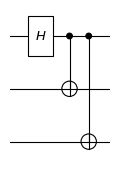

In [8]:
# 输出量子电路
print('第一种量子电路输出方式：')
print()
print(ghz_3_cir)
print('第二种量子电路输出方式：\n')
ghz_3_cir.plot()

### 量子门的一般性构造

接下来，我们以在量子电路中设置单比特 $R_y, R_x, R_z$ 门和两比特 CNOT 门为例，展示如何进行添加或删减量子门的一般性构造。

添加量子门后的电路为：


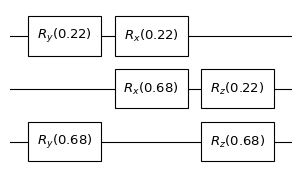

删除量子门后的电路为：


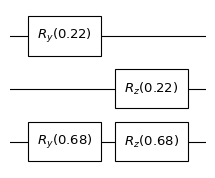

In [9]:
# 创建 3 量子比特电路
cir = Circuit(3)
# 设置参数并自定义量子门，这里我们选择 Ry, Rx, Rz 门
param = np.random.rand(2)
ry_gate = RY(param=param, qubits_idx=[0, 2])  # 参数可选填，默认情况下 RY 类随机生成一组参数
rx_gate = RX(param=param, qubits_idx=[0, 1])
rz_gate = RZ(param=param, qubits_idx=[1, 2])
# 在量子电路中插入量子门
cir.append(ry_gate)
cir.append(rx_gate)
cir.insert(index=2, operator=rz_gate)  # index 指定插入的位置，operator 指定插入的量子门
# 输出量子电路，这里我们选择较直观的 plot 方法
print('添加量子门后的电路为：')
cir.plot()

# 在量子电路中删除 Rx 门
cir.pop(index=1, operator=rx_gate)  # index 指定删除的位置，operator 指定删除的量子门，该参数可选择输入
print('删除量子门后的电路为：')
cir.plot()

除了利用 `append` 这类方法插入量子门外，还可以用下述方式实现量子门的设置：

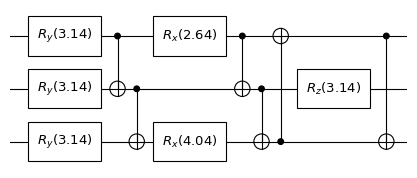

In [10]:
# 创建 3 量子比特电路
cir = Circuit(3)
# 设置参数
theta = np.full([2], np.pi)
# 设置量子门
# 单量子比特 Ry 门
cir.ry(qubits_idx='full', param=theta[0])  # qubits_idx='full' 指定量子门作用在所有编号的量子比特上，单比特量子门的 qubits_idx 默认为 full；param 指定输入参数，默认情况下由 Ry 门随机生成
# 两量子比特 CNOT 门
cir.cnot(qubits_idx='linear')  # qubits_idx='linear' 指定量子门作用方式为 linear，多比特量子门的 qubits_idx 默认为 cycle
# 单量子比特 Rx 门
cir.rx(qubits_idx='even')  # qubits_idx='even' 指定量子门作用在编号为偶数的量子比特上，默认为 full；param 指定输入参数，默认情况下由 Rx 门随机生成
# 两量子比特 CNOT 门
cir.cnot(qubits_idx='cycle')  # qubits_idx='cycle' 指定量子门作用方式为 cycle，多比特量子门的 qubits_idx 默认为 cycle
# 单量子比特 Rz 门
cir.rz(qubits_idx='odd', param=theta[1])  # qubits_idx='odd' 指定量子门作用在编号为奇数的量子比特上，默认为 full；param 指定输入参数，默认情况下由 Rz 门随机生成
# 两量子比特 CNOT 门
cir.cnot([0, 2])  # qubits_idx 为 list 指定量子门作用在编号为 0 和 2 的量子比特上，其中 0 为控制位 2 为受控位
# 输出量子电路
cir.plot()

前面提到的构造量子电路都需要给定量子电路大小，即量子比特数，除了这种方式外，量桨还提供了不需要输入量子比特数的动态电路构造方式，下面我们给出一简单示例来展示该类型电路的构造方法。

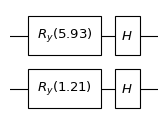

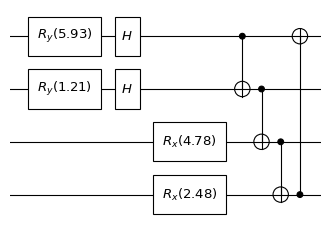

In [11]:
cir = Circuit()  # 未指定电路大小
cir.ry([0, 1])  # 电路大小更新为 2
cir.h()  # 以总比特数为 2 设置 Hadamard 门
cir.plot()  # 绘制此时的 2 比特电路
cir.rx([2, 3])  # 电路大小根据量子门的添加更新为 4
cir.cnot()  # 以总比特数为 4 设置 CNOT 门
cir.plot()  # 绘制更新后的 4 比特电路